# [ LG에너지솔루션 DX Expert 양성과정 ]

Vision Transformer를 활용한 image classification



<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240703_Transfomer/image/ViT01.png?raw=true" width="600">

---

In [2]:
!pip install timm==0.9.2
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 544.0 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.7 MB/s eta 0:00:00:00:0100:01


# Import modules

In [3]:
# 필수 라이브러리 임포트
import os  # 운영체제 관련 기능
import random  # 무작위 수 생성
import numpy as np  # 숫자 계산
import pandas as pd  # 데이터 처리 및 분석
from collections import defaultdict  # 기본값이 있는 딕셔너리 생성
from time import time  # 시간 측정
from tqdm.auto import tqdm  # 진행률 표시

# scikit-learn의 평가 지표 임포트
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

# PyTorch 라이브러리 임포트
import torch  # 딥러닝 프레임워크
import torch.nn as nn  # 신경망 모듈
from torch.optim import SGD  # 최적화 알고리즘
from torch.utils.data import Dataset, DataLoader  # 데이터셋 및 데이터 로더
from torchvision import transforms, datasets  # 데이터 변환 및 데이터셋

# TIMM 라이브러리 임포트 (모델 생성용)
from timm import list_models, create_model

# OpenCV와 Matplotlib 임포트 (이미지 처리 및 시각화)
import cv2  # 이미지 처리 라이브러리
import matplotlib.pyplot as plt  # 시각화 라이브러리

# Seaborn 설정 (더 나은 시각화 설정)
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# 추가 라이브러리 임포트
from einops import rearrange  # 텐서 조작에 유용, 필요한 경우 사용

# Functions

In [4]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

def calc_metrics(y_true: list, y_score: np.ndarray, y_pred: list) -> dict:
    # softmax
    y_score = nn.functional.softmax(torch.FloatTensor(y_score), dim=1)

    # metrics
    auroc = roc_auc_score(y_true, y_score, average='macro', multi_class='ovr')
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')

    return {
        'auroc'    : auroc,
        'f1'       : f1,
        'recall'   : recall,
        'precision': precision
    }

def train(model, dataloader, criterion, optimizer, log_interval: int, device: str) -> list:

    correct = 0
    total = 0
    total_loss = 0
    total_score = []
    total_preds = []
    total_targets = []

    model.train()

    for i, (inputs, targets) in enumerate(dataloader):
        # convert device
        inputs, targets = inputs.to(device), targets.to(device)

        # model outputs
        outputs = model(inputs)

        # loss
        loss = criterion(outputs, targets)

        # calculate gradients
        loss.backward()

        # update model weights
        optimizer.step()
        optimizer.zero_grad()

        # total loss and acc
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)

        correct += targets.eq(preds).sum().item()
        total += targets.size(0)

        total_score.extend(outputs.cpu().tolist())
        total_preds.extend(preds.cpu().tolist())
        total_targets.extend(targets.cpu().tolist())

        # log learning history
        if i % log_interval == 0 or (i+1) == len(dataloader):
            print('TRAIN [%5d/%5d]: Loss: %.3f | Acc: %.3f%% [%5d/%5d]' %
                 (i+1, len(dataloader), total_loss/(i+1), 100.*correct/total, correct, total))

    # calculate metrics
    metrics = calc_metrics(
        y_true  = total_targets,
        y_score = total_score,
        y_pred  = total_preds
    )

    metrics.update([('acc',correct/total), ('loss',total_loss/len(dataloader))])

    # logging metrics
    print('\nTRAIN: Loss: %.3f | Acc: %.3f%% | AUROC: %.3f%% | F1-Score: %.3f%% | Recall: %.3f%% | Precision: %.3f%%\n' %
         (metrics['loss'], 100.*metrics['acc'], 100.*metrics['auroc'], 100.*metrics['f1'], 100.*metrics['recall'], 100.*metrics['precision']))


    return metrics

def test(model, dataloader, criterion, log_interval: int, device: str) -> list:

    correct = 0
    total = 0
    total_loss = 0
    total_score = []
    total_preds = []
    total_targets = []

    torch_seed(223)
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            # convert device
            inputs, targets = inputs.to(device), targets.to(device)

            # model outputs
            outputs = model(inputs)

            # loss
            loss = criterion(outputs, targets)

            # total loss and acc
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)

            correct += targets.eq(preds).sum().item()
            total += targets.size(0)

            total_score.extend(outputs.cpu().tolist())
            total_preds.extend(preds.cpu().tolist())
            total_targets.extend(targets.cpu().tolist())

            # log learning history
            if i % log_interval == 0 or (i+1) == len(dataloader):
                print('TEST [%5d/%5d]: Loss: %.3f | Acc: %.3f%% [%5d/%5d]' %
                      (i+1, len(dataloader), total_loss/(i+1), 100.*correct/total, correct, total))

    # calculate metrics
    metrics = calc_metrics(
        y_true  = total_targets,
        y_score = total_score,
        y_pred  = total_preds
    )

    metrics.update([('acc',correct/total), ('loss',total_loss/len(dataloader))])

    # logging metrics
    print('\nTEST: Loss: %.3f | Acc: %.3f%% | AUROC: %.3f%% | F1-Score: %.3f%% | Recall: %.3f%% | Precision: %.3f%%\n' %
         (metrics['loss'], 100.*metrics['acc'], 100.*metrics['auroc'], 100.*metrics['f1'], 100.*metrics['recall'], 100.*metrics['precision']))

    # return
    return metrics


def fit(
    model, trainloader, testloader, criterion, optimizer, epochs: int, log_interval: int, device: str) -> list:

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    # fitting model
    for i in range(epochs):
        print(f'\nEpoch: [{i+1}/{epochs}]')
        train_metrics = train(
            model        = model,
            dataloader   = trainloader,
            criterion    = criterion,
            optimizer    = optimizer,
            log_interval = log_interval,
            device       = device,
        )

        test_metrics = test(
            model        = model,
            dataloader   = testloader,
            criterion    = criterion,
            log_interval = log_interval,
            device       = device
        )

        # stack history
        for k, v in train_metrics.items():
            train_history[k].append(v)
        for k, v in test_metrics.items():
            test_history[k].append(v)

    return train_history, test_history

# Configuration for experiments

In [5]:
class Config:
    # dataset 관련 parameters
    datadir = './data'
    image_size = [32, 32]
    num_classes = 10

    # training 관련 parameters
    epochs = 10
    batch_size = 32
    test_batch_size = 128
    learning_rate = 0.001
    num_workers = 2
    log_interval = 200

    # device
    device = 'cuda'

    # seed
    seed = 223

cfg = Config()

# Load dataset and dataloader

In [6]:
trainset = datasets.CIFAR10(root=cfg.datadir, train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root=cfg.datadir, train=False, download=True, transform=transforms.ToTensor())

100%|█████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:14<00:00, 11499258.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
trainloader = DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
testloader = DataLoader(testset, batch_size=cfg.test_batch_size, shuffle=False, num_workers=cfg.num_workers)

In [8]:
print('the number of images in trainset: ',len(trainset.data))
print('the number of images in testset: ',len(testset.data))
print()
print('image size: ',trainset.data[0].shape)
print('target category')
print(trainset.class_to_idx)

the number of images in trainset:  50000
the number of images in testset:  10000

image size:  (32, 32, 3)
target category
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


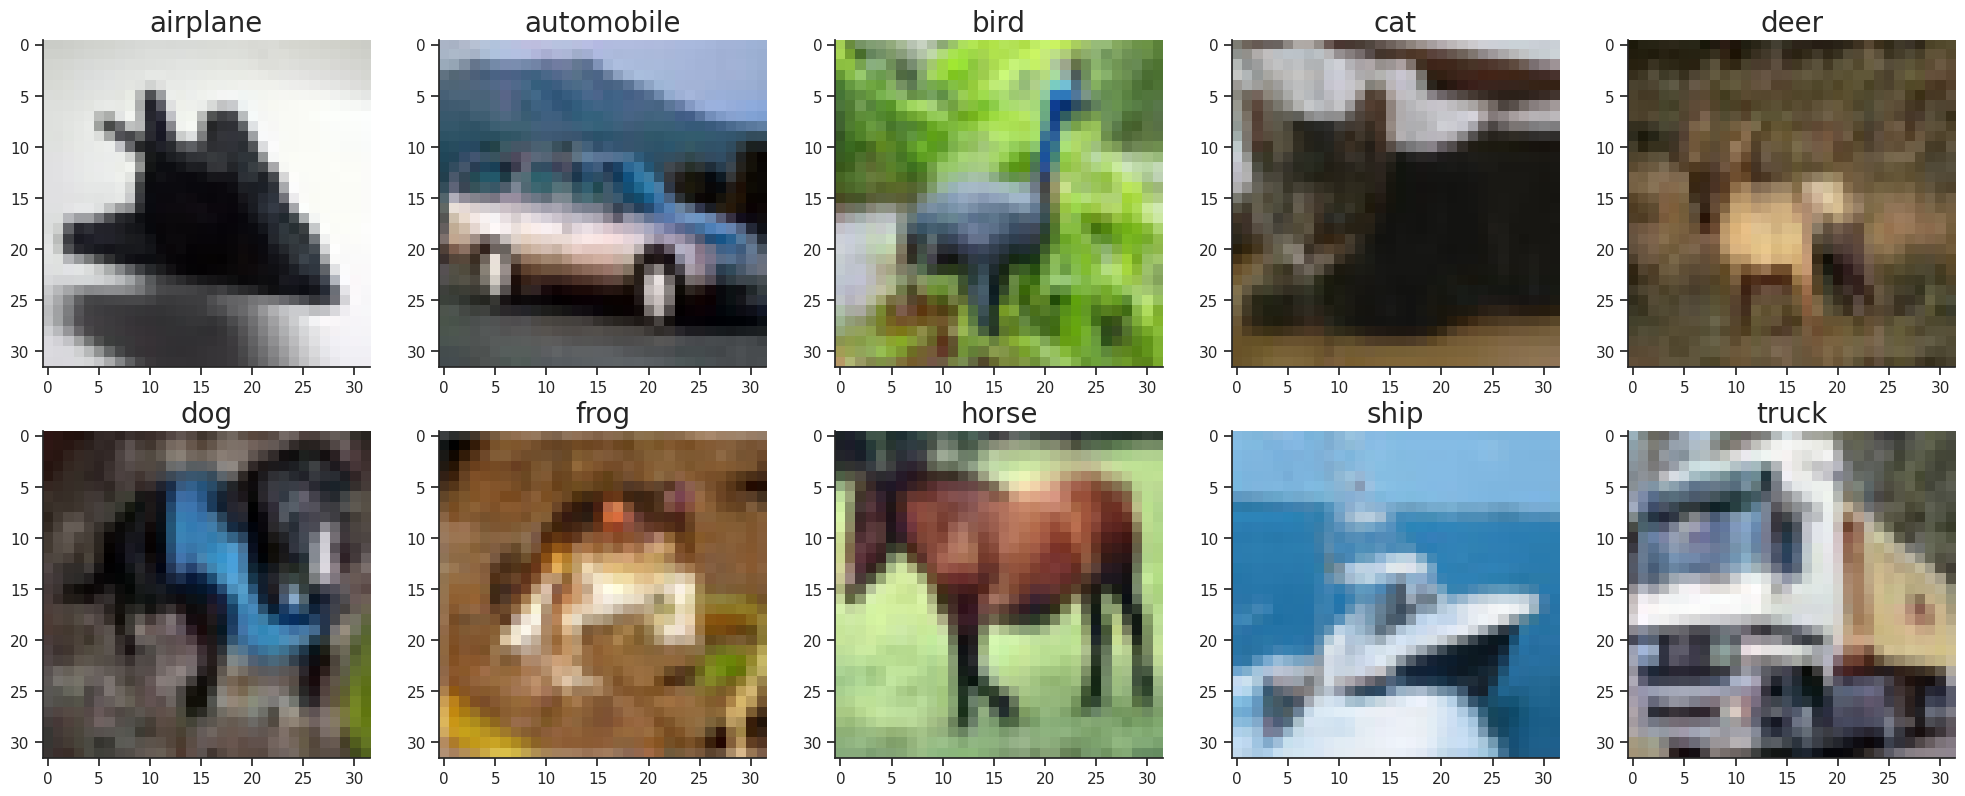

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(20,8))

for i in range(10):
    idx = torch.where(torch.Tensor(trainset.targets)==i)[0][0]
    ax[i//5, i%5].imshow(trainset[idx][0].permute(1,2,0))
    ax[i//5, i%5].set_title(list(trainset.class_to_idx.keys())[i], size=20)
plt.tight_layout()
plt.show()

# Vision Transformer

## without pretrained weights

In [10]:
model_wo_pretrained = create_model(
    model_name  = 'vit_base_patch8_224',
    img_size    = cfg.image_size,
    num_classes = cfg.num_classes
)
model_wo_pretrained.to(cfg.device)
print('load model')
print('The number of model parameters: ',sum([p.numel() for p in model_wo_pretrained.parameters()]))

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_wo_pretrained.parameters(), lr=cfg.learning_rate)

load model
The number of model parameters:  85225738


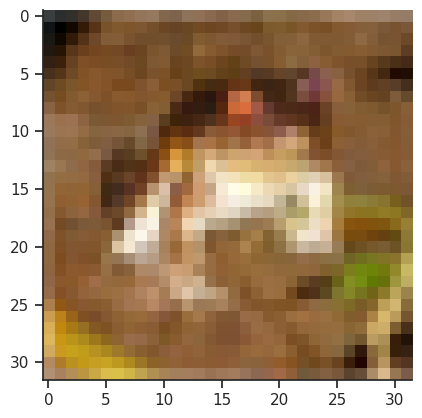

In [11]:
img_temp = trainset[0][0]
plt.imshow(img_temp.permute(1,2,0))
plt.show()

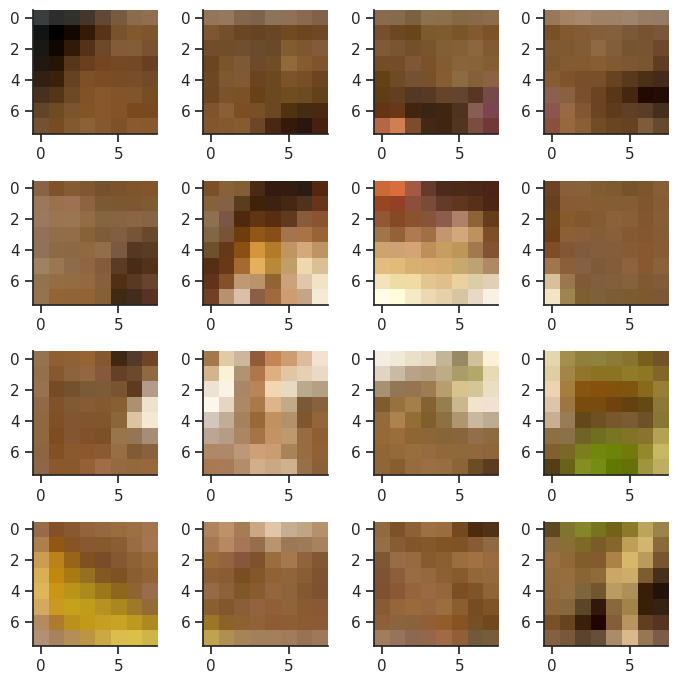

In [12]:
# patchify
img_temp_patch = rearrange(img_temp, 'c (h ph) (w pw) -> (h w) (ph pw c)', ph=8, pw=8)

fig, ax = plt.subplots(4,4,figsize=(7,7))

for i in range(len(img_temp_patch)):
    ax[i//4, i%4].imshow(img_temp_patch[i].reshape(8, 8, 3))

plt.tight_layout()
plt.show()

In [13]:
# patch embedding
temp_out = model_wo_pretrained.patch_embed(img_temp.unsqueeze(0).to(cfg.device))
print(temp_out.shape)

torch.Size([1, 16, 768])


In [14]:
# encoder outputs
temp_out = model_wo_pretrained.forward_features(img_temp.unsqueeze(0).to(cfg.device))
print(temp_out.shape)

torch.Size([1, 17, 768])


In [15]:
# head outputs
temp_out = model_wo_pretrained.head(temp_out[:,0,:])
print(temp_out.shape)

torch.Size([1, 10])


### Training model

In [16]:
torch_seed(cfg.seed)
train_history_wo_pretrained, test_history_wo_pretrained = fit(
    model        = model_wo_pretrained,
    trainloader  = trainloader,
    testloader   = testloader,
    criterion    = criterion,
    optimizer    = optimizer,
    epochs       = cfg.epochs,
    log_interval = cfg.log_interval,
    device       = cfg.device
)


Epoch: [1/10]
TRAIN [    1/ 1563]: Loss: 2.445 | Acc: 15.625% [    5/   32]
TRAIN [  201/ 1563]: Loss: 2.197 | Acc: 17.335% [ 1115/ 6432]
TRAIN [  401/ 1563]: Loss: 2.142 | Acc: 19.514% [ 2504/12832]
TRAIN [  601/ 1563]: Loss: 2.109 | Acc: 20.975% [ 4034/19232]
TRAIN [  801/ 1563]: Loss: 2.089 | Acc: 21.696% [ 5561/25632]
TRAIN [ 1001/ 1563]: Loss: 2.071 | Acc: 22.471% [ 7198/32032]
TRAIN [ 1201/ 1563]: Loss: 2.053 | Acc: 23.264% [ 8941/38432]
TRAIN [ 1401/ 1563]: Loss: 2.040 | Acc: 23.840% [10688/44832]
TRAIN [ 1563/ 1563]: Loss: 2.031 | Acc: 24.254% [12127/50000]

TRAIN: Loss: 2.031 | Acc: 24.254% | AUROC: 71.824% | F1-Score: 23.521% | Recall: 24.254% | Precision: 23.369%

TEST [    1/   79]: Loss: 1.907 | Acc: 25.781% [   33/  128]
TEST [   79/   79]: Loss: 1.964 | Acc: 27.840% [ 2784/10000]

TEST: Loss: 1.964 | Acc: 27.840% | AUROC: 77.500% | F1-Score: 24.646% | Recall: 27.840% | Precision: 36.523%


Epoch: [2/10]
TRAIN [    1/ 1563]: Loss: 1.972 | Acc: 34.375% [   11/   32]
TRAIN

In [17]:
def figure(all_train_history: list, all_test_history: list, all_exp_name: list) -> None:
    fig, ax = plt.subplots(2, 6, figsize=(20,7))

    # train line plot
    for train_h, exp_name in zip(all_train_history, all_exp_name):
        for i, (k, v) in enumerate(train_h.items()):
            sns.lineplot(
                x     = range(1, len(v)+1),
                y     = v,
                label = exp_name,
                ax    = ax[0, i]
            )
            # set y axis label
            ax[0, i].set_ylabel(f'{k.upper()}')
            # set x axis label
            ax[0, i].set_xlabel('Epochs')
            # set title
            ax[0, i].set_title(f'{k.upper()} of Trainset')
            # set legend
            ax[0, i].legend(loc='lower right')
            # set ylim
            if k != 'loss':
                ax[0, i].set_ylim(0, 1)

    # test lineplot
    for test_h, exp_name in zip(all_test_history, all_exp_name):
        for i, (k, v) in enumerate(test_h.items()):
            sns.lineplot(
                x     = range(1, len(v)+1),
                y     = v,
                label = exp_name,
                ax    = ax[1, i]
            )
            # set y axis label
            ax[1, i].set_ylabel(f'{k.upper()}')
            # set x axis label
            ax[1, i].set_xlabel('Epochs')
            # set title
            ax[1, i].set_title(f'{k.upper()} of Testset')
            # set legend
            ax[1, i].legend(loc='lower right')
            # set ylim
            if k != 'loss':
                ax[0, i].set_ylim(0, 1)


    plt.tight_layout()
    plt.show()

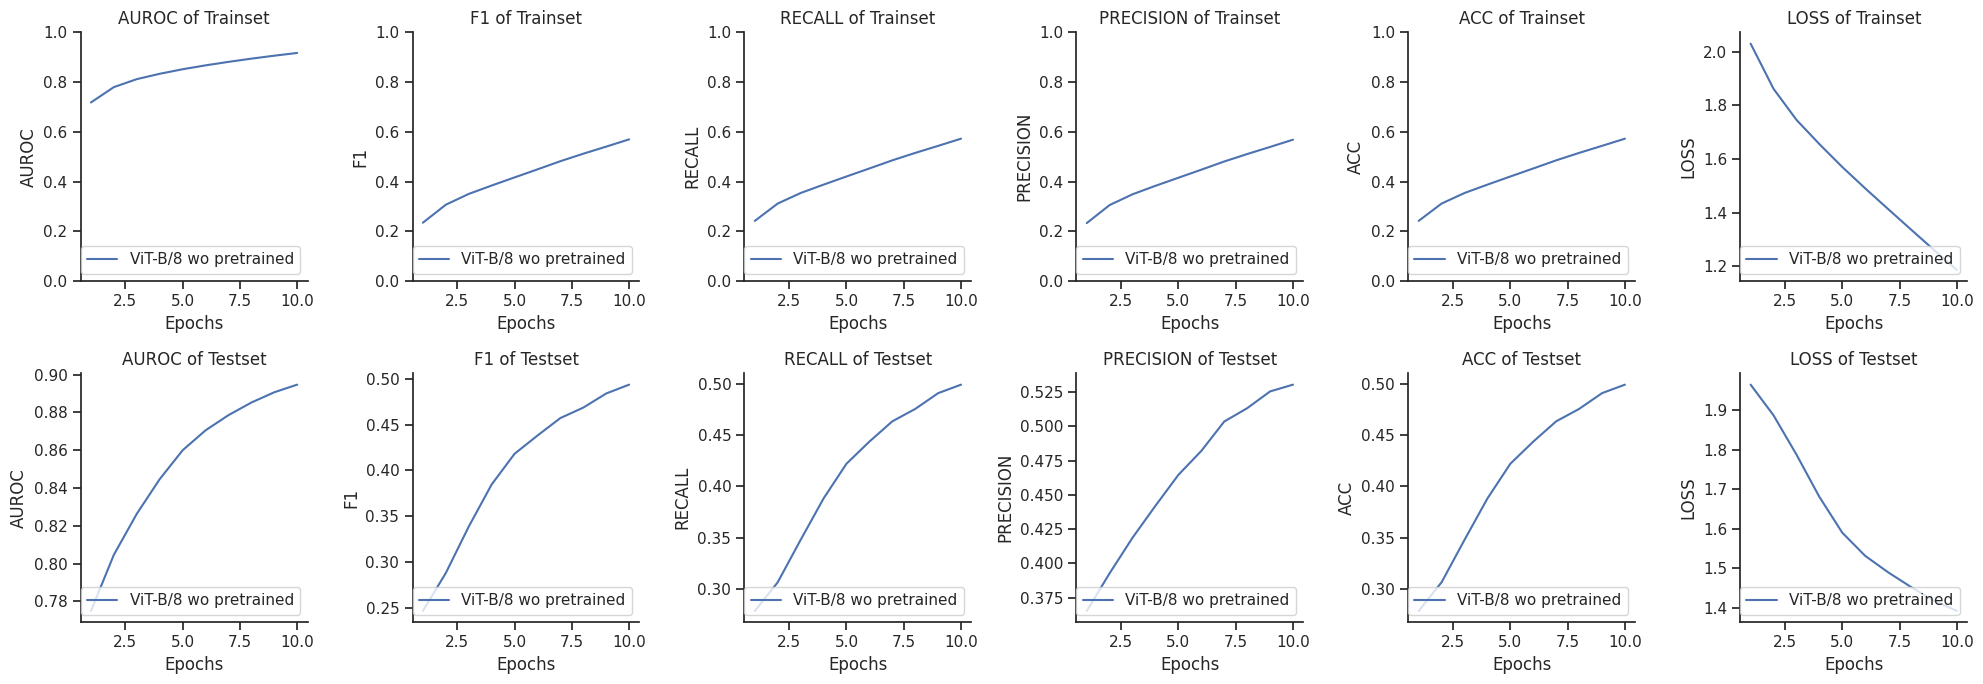

In [18]:
all_train_history = [train_history_wo_pretrained]
all_test_history = [test_history_wo_pretrained]
all_exp_name = ['ViT-B/8 wo pretrained']

figure(
    all_train_history = all_train_history,
    all_test_history  = all_test_history,
    all_exp_name      = all_exp_name
)

## with pretrained weights

In [19]:
model_w_pretrained = create_model(
    model_name  = 'vit_base_patch8_224.augreg_in21k',
    img_size    = cfg.image_size,
    num_classes = cfg.num_classes,
    pretrained  = True
)
model_w_pretrained.to(cfg.device)
print('load model')
print('The number of model parameters: ',sum([p.numel() for p in model_w_pretrained.parameters()]))

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_w_pretrained.parameters(), lr=cfg.learning_rate)

model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

load model
The number of model parameters:  85225738


### Training model

In [20]:
torch_seed(cfg.seed)
train_history_w_pretrained, test_history_w_pretrained = fit(
    model        = model_w_pretrained,
    trainloader  = trainloader,
    testloader   = testloader,
    criterion    = criterion,
    optimizer    = optimizer,
    epochs       = cfg.epochs,
    log_interval = cfg.log_interval,
    device       = cfg.device
)


Epoch: [1/10]
TRAIN [    1/ 1563]: Loss: 2.778 | Acc: 12.500% [    4/   32]
TRAIN [  201/ 1563]: Loss: 2.105 | Acc: 21.922% [ 1410/ 6432]
TRAIN [  401/ 1563]: Loss: 1.977 | Acc: 26.956% [ 3459/12832]
TRAIN [  601/ 1563]: Loss: 1.868 | Acc: 31.437% [ 6046/19232]
TRAIN [  801/ 1563]: Loss: 1.772 | Acc: 35.128% [ 9004/25632]
TRAIN [ 1001/ 1563]: Loss: 1.682 | Acc: 38.377% [12293/32032]
TRAIN [ 1201/ 1563]: Loss: 1.595 | Acc: 41.567% [15975/38432]
TRAIN [ 1401/ 1563]: Loss: 1.516 | Acc: 44.535% [19966/44832]
TRAIN [ 1563/ 1563]: Loss: 1.457 | Acc: 46.758% [23379/50000]

TRAIN: Loss: 1.457 | Acc: 46.758% | AUROC: 87.099% | F1-Score: 46.317% | Recall: 46.758% | Precision: 46.159%

TEST [    1/   79]: Loss: 1.013 | Acc: 59.375% [   76/  128]
TEST [   79/   79]: Loss: 1.033 | Acc: 61.810% [ 6181/10000]

TEST: Loss: 1.033 | Acc: 61.810% | AUROC: 95.078% | F1-Score: 61.572% | Recall: 61.810% | Precision: 70.049%


Epoch: [2/10]
TRAIN [    1/ 1563]: Loss: 0.649 | Acc: 84.375% [   27/   32]
TRAIN

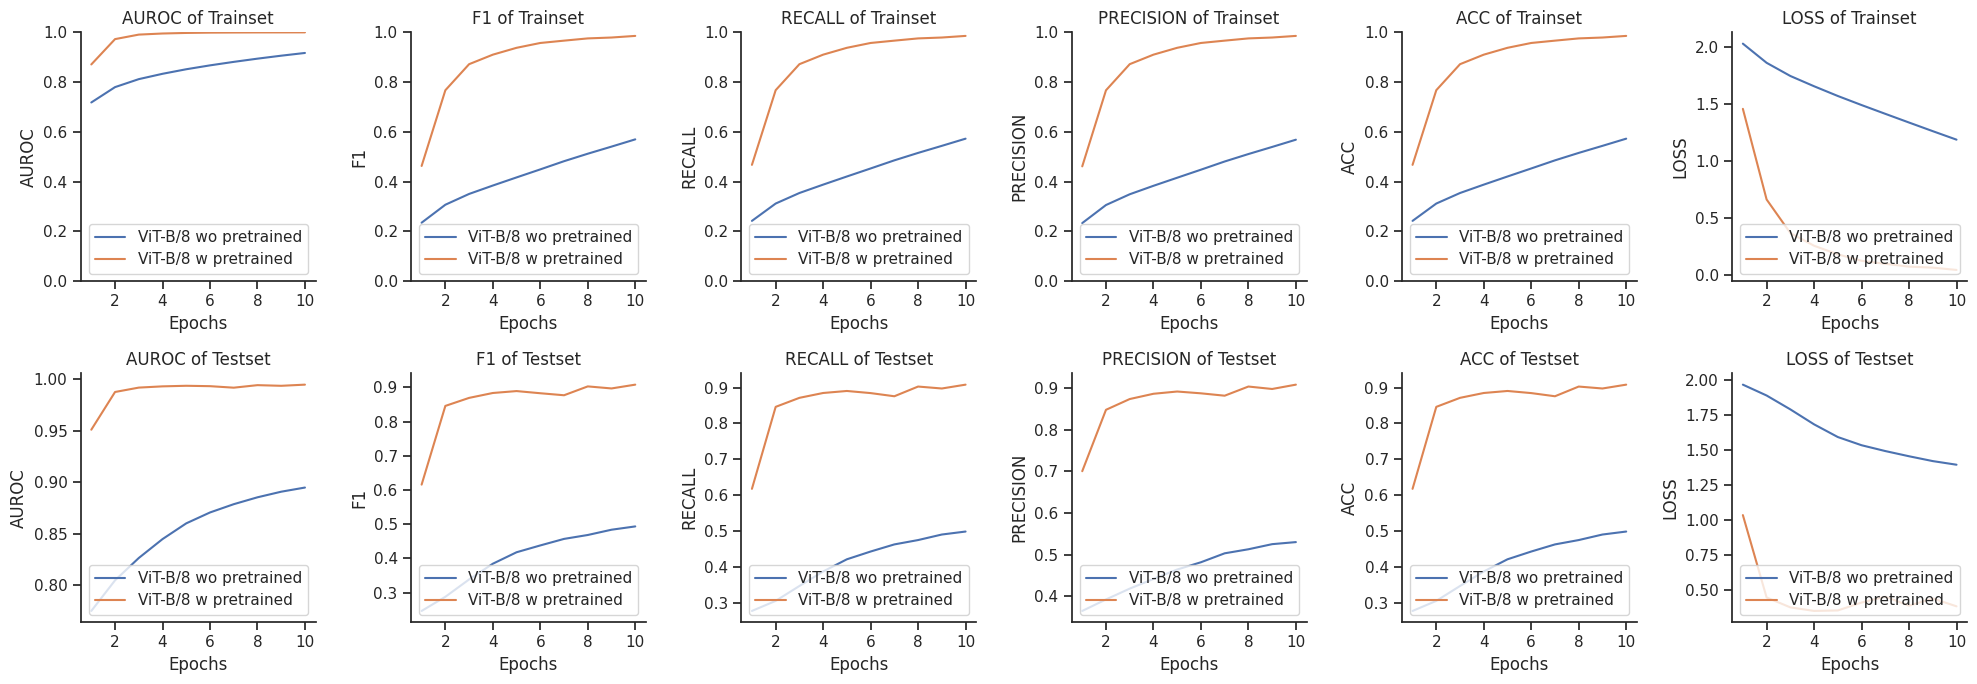

In [21]:
all_train_history.append(train_history_w_pretrained)
all_test_history.append(test_history_w_pretrained)
all_exp_name.append('ViT-B/8 w pretrained')

figure(
    all_train_history = all_train_history,
    all_test_history  = all_test_history,
    all_exp_name      = all_exp_name
)

# Visualization

## Position embedding

In [22]:
def pos_cos_figure(model):
    # 모델의 위치 임베딩에서 첫 번째 패치의 길이를 가져옵니다.
    num_patch = int(len(model.pos_embed[0]) - 1)
    # 패치의 수에 따라 히트맵의 행과 열의 수를 계산합니다.
    row = int(np.sqrt(num_patch))
    col = int(np.sqrt(num_patch))

    # 행과 열의 수를 바탕으로 서브플롯을 생성합니다.
    fig, ax = plt.subplots(row, col, figsize=(7,7))

    # 각 패치의 위치 임베딩 간의 유사도를 계산합니다.
    for p_i in range(num_patch):
        sim_matrix_i = np.zeros((row, col))
        for p_j in range(num_patch):
            sim_matrix_i[p_j//col, p_j%col] = nn.functional.cosine_similarity(
                x1  = model.pos_embed[0, p_i+1, :],
                x2  = model.pos_embed[0, p_j+1, :],
                dim = 0
            ).item()

        # 계산된 유사도를 히트맵으로 시각화합니다.
        sns.heatmap(sim_matrix_i, cmap='viridis', vmax=1, ax=ax[p_i//col, p_i%col])
        ax[p_i//col, p_i%col].axis('off')

    # 레이아웃을 조정하고, 히트맵을 출력합니다.
    plt.tight_layout()
    plt.show()

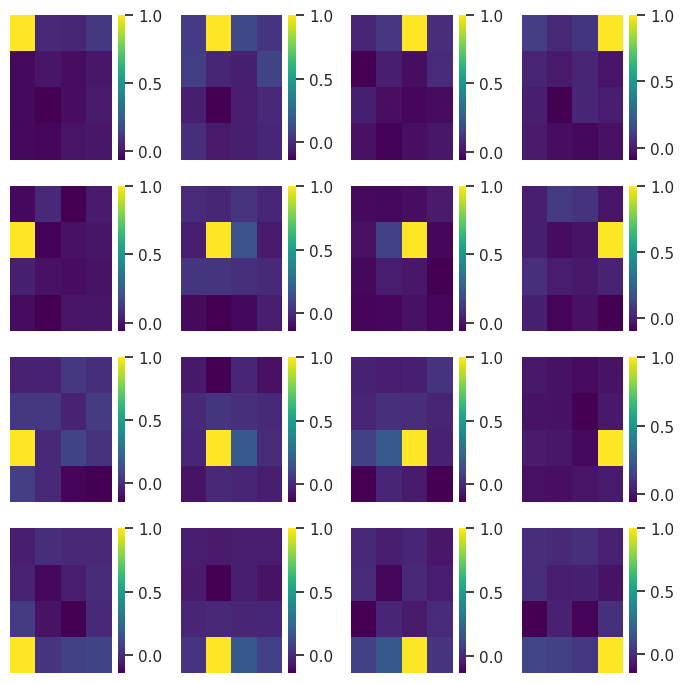

In [23]:
pos_cos_figure(model_wo_pretrained)

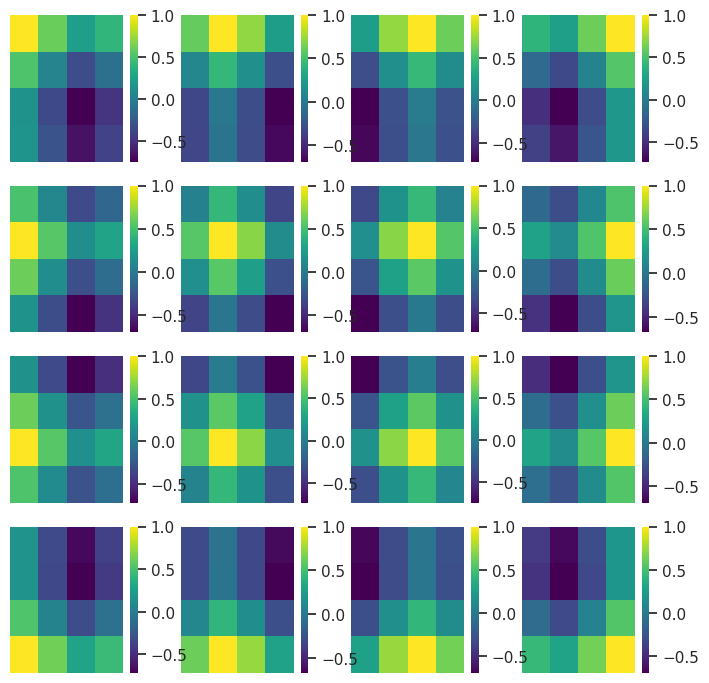

In [24]:
pos_cos_figure(model_w_pretrained)

## Visualize attention map

In [25]:
activation = {}

# 어텐션 스코어를 계산하여 저장하는 함수
def get_attn_softmax(name):
    def hook(model, input, output):
        with torch.no_grad():
            input = input[0]
            
            # 입력의 크기를 가져옴
            B, N, C = input.shape
            
            # QKV 분해
            qkv = model.qkv(input).detach().reshape(B, N, 3, model.num_heads, C // model.num_heads) 
            # QKV의 shape: (B, N, 3, num_heads, C // num_heads)
            qkv = qkv.permute(2, 0, 3, 1, 4) 
            # QKV의 shape: (3, B, num_heads, N, C // num_heads)
            
            # Q, K, V 추출
            q, k, v = qkv[0], qkv[1], qkv[2]
            # Q, K, V의 shape: (B, num_heads, N, C // num_heads)
            
            # 어텐션 계산
            attn = (q @ k.transpose(-2, -1)) * model.scale
            attn = attn.softmax(dim=-1)
            # attn의 shape: (B, num_heads, N, N)
            
            # 결과 저장
            activation[name] = attn

    return hook

# 모델의 모든 블록에 어텐션 후크 추가
def add_attn_vis_hook(model):
    # 모델의 모든 블록을 순회합니다.
    for idx, module in enumerate(model.blocks.children()):
        # 각 블록의 어텐션 모듈에 get_attn_softmax 함수를 후크로 등록합니다.
        module.attn.register_forward_hook(get_attn_softmax(f"attn{idx}"))

# 어텐션 스코어와 이미지를 블렌딩하는 함수
def blend_attention_with_image(image: np.ndarray, activation: dict):
    # 어텐션 어그리게이션
    attn_agg = torch.cat(list(activation.values())).sum(dim=(0,1))[0, 1:].softmax(dim=0).cpu().numpy()
    # (num_layers * B, num_heads, N, N) -> (N, N) -> (N-1,)
    attn_agg = attn_agg.reshape(4, 4)
    attn_agg = cv2.resize(attn_agg, dsize=(32, 32))
    
    # 스케일링
    attn_agg = (attn_agg - attn_agg.min()) / (attn_agg.max() - attn_agg.min())
    
    # 블렌딩
    attn_agg = np.expand_dims(attn_agg, axis=-1) # (32, 32, 1)
    img_blend = image * 0.5 + attn_agg * 0.8
    
    # 스케일링
    img_blend = (img_blend - img_blend.min()) / (img_blend.max() - img_blend.min())
    
    return img_blend

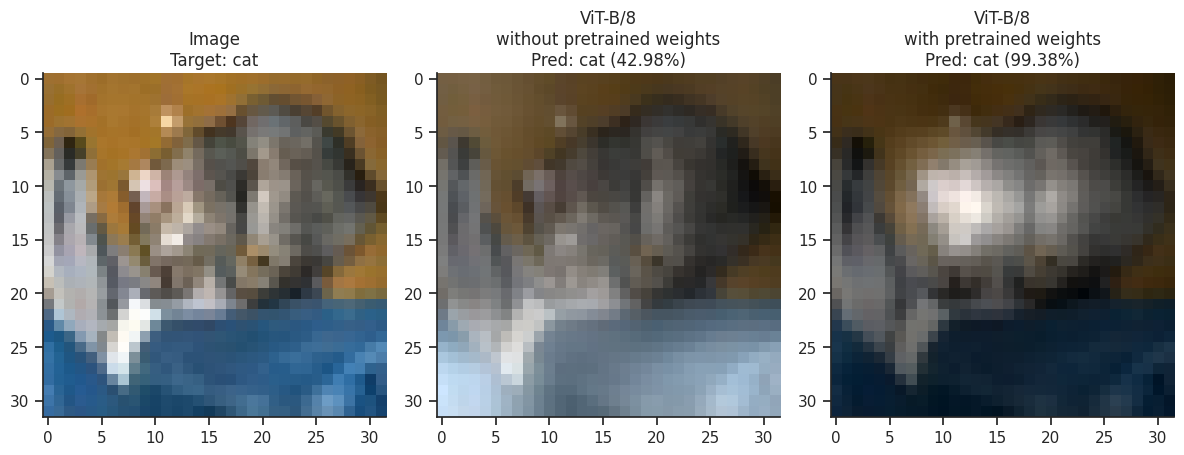

In [26]:
img, target = testset[0]
img_show = img.permute(1,2,0).numpy()

# target
class_name = list(testset.class_to_idx.keys())
target_name = class_name[target]

# with pretrained weights
add_attn_vis_hook(model_wo_pretrained)
output = model_wo_pretrained(img.unsqueeze(0).to(cfg.device))
pred_wo_pretrained = output.argmax(dim=1)[0].item()
prob_wo_pretrained = nn.functional.softmax(output, dim=1)[0][pred_wo_pretrained]

img_blend_wo_pretrained = blend_attention_with_image(image=img_show, activation=activation)

# with pretrained weights
add_attn_vis_hook(model_w_pretrained)
output = model_w_pretrained(img.unsqueeze(0).to(cfg.device))
pred_w_pretrained = output.argmax(dim=1)[0].item()
prob_w_pretrained = nn.functional.softmax(output, dim=1)[0][pred_w_pretrained]

img_blend_w_pretrained = blend_attention_with_image(image=img_show, activation=activation)

# figure
fig, ax = plt.subplots(1,3,figsize=(12,5))

ax[0].imshow(img_show)
ax[1].imshow(img_blend_wo_pretrained)
ax[2].imshow(img_blend_w_pretrained)

# set title
ax[0].set_title(f'Image\nTarget: {target_name}')
ax[1].set_title(f'ViT-B/8\nwithout pretrained weights\nPred: {class_name[pred_wo_pretrained]} ({prob_wo_pretrained:.2%})')
ax[2].set_title(f'ViT-B/8\nwith pretrained weights\nPred: {class_name[pred_w_pretrained]} ({prob_w_pretrained:.2%})')
plt.tight_layout()
plt.show()

---